In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random
using DelimitedFiles
using ForwardDiff
using HaltonSequences

## General setup


### 1. Continuous case
We define the cost function to be the following: 
\begin{equation}
	J(u):=\mathbb{E}[\Phi(X_T, \Gamma)]
\end{equation}
    where $\Gamma$ is the real data available, which consists of the input $\vec{x}$ and the output $\vec{y}$. 

And $X_T$ is defined through the folowing process 

\begin{equation}
	X_T=X_0 + \int^T_0 f(X_s,u_s) ds + \int^T_0 g(u_s) dW_s, \  0 \leq s \leq T
\end{equation}

the drift function $f,g$ are to be determined.

The goal is to find control $u \in U$, where $U$ is the admissible set, such that 

\begin{align}
J^*\equiv J(u^*) = \min_{u \in U} J(u)
\end{align}




Introducing the adjoint process $(Y_t, Z_t)$, we introduce the following BSDE 
\begin{equation}
	dY_t=-(f'_x(X_t, u_t) Y_t + g'_x(X_t) Z_t) dt + Z_t dW_t, \ \  Y_T= \Phi'_x(X_T,\Gamma)
\end{equation}

The gradient process is found to be:
\begin{equation}\label{proj_cont}
	J'_u(t, u_t)=\mathbb{E}[f'_u (X_t,u_t)^T Y_t + g'(u)^T Z_t ]
\end{equation}

And we optimize the control parameter in the following fashion: 

\begin{equation}
	u^{k+1}=(u^k-\eta_k J'_u), \ k=0,1,2...
\end{equation}

### 2. Numerical scheme


The numerical scheme takes the following form: 
\begin{align}
X^k_{n+1} &=X^k_n+f(X^k_n,u^k_n)h+g(u^k_n) \sqrt{h} w^k_n  \label{x_sch} , \ w^k_n \sim \mathcal{N}(0,1)  \\
	Y^k_n &=Y^{k}_{n+1}+h \big( f'_x(X^k_n,u^k_n) Y^k_{n+1} + g'_x(X^k_n,u^{k}_n)Z_n^k \big)  \label{y_sch2}  \\
	Z^k_n &= \frac{Y^k_{n+1} \sqrt{h} w_n^k}{h} \label{z_sch2} 
\end{align} 
and the sample gradient takes the following form:
\begin{align}
	j'(u)|_{t=t_n}= f_u(X_n^k,u^k_{t_n})^TY^k_n  + g'_u(u^k_{t_n})Z^k_n  \label{SGD2}
\end{align}

Inspired by the method of SGD, we propose the following algorithm.
\begin{align}
	u^{k+1}_n= u^k_n-\eta_k \Big( f_u(X_n^k,u^k_{t_n})^TY^k_n +g^T_u(u^k_{t_n}) Z^k_n \Big)  \label{SGD}
\end{align}






## Function approximation



 Suppose that the problem is of dimension $d$, and the function of interest is 
    $$F: \mathbb{R}^d \rightarrow \mathbb{R}$$

We define $X_{d+1}=F(X_1, X_2, ..., X_d)$, and we stack up the input and the output to make a vector of dimension $d+1$. 

Then the goal is to learn the graph of the following function 
\begin{align}
\begin{bmatrix} X_1  \\ ...\\ X_{d}  \\ F(X_1, X_2, ..., X_d) \end{bmatrix} = 
\begin{bmatrix} X_1  \\ ...\\ X_{d}  \\ X_{d+1} \end{bmatrix}
\end{align}

We propose the following neural network structure (continuous version): 

\begin{align}
d \begin{bmatrix} X_1  \\ ...\\ X_d \\ X_{d+1} \end{bmatrix}=
   \begin{bmatrix} 0  \\ 
   ... \\
   0\\
   \sum^{L}_{l=1} a_l \sigma(\sum^{d+1}_{i=1} w_{li} X_i +b_l) 
   \end{bmatrix} dt + \begin{bmatrix} 
    \sigma_c \\
   ...\\ \sigma_c \\ 
   \sigma(u) \\
   \end{bmatrix}
    \odot
    \begin{bmatrix} dW_1  \\ ...\\dW_d \\ dW_{d+1}  \end{bmatrix}
\end{align}
   
 
 The control matrix for the diffusion part has three parts. 
 
 We assume that the drift takes the form of a linear comination of sigmoid functions 
 1. The control consists of the following components 
 \begin{align}
 \mathbf{u}= \Big \lbrace a^n_l , \lbrace \omega^n_{li} \rbrace^{d+1}_{i=1} , b^n_l, u^n \Big \rbrace^{L,N}_{l=1,n=1}
 \end{align}
 
 where $n=1,...,N$ stands for the number of layers, and $L$ stands for the number of neurons at each layer. 
 2. Now, the discrete version of the scheme takes the following form: 
\begin{align}
 \begin{bmatrix} X^{n+1}_1  \\ ...\\ X^{n+1}_d  \\ X^{n+1}_{d+1} \end{bmatrix} = \begin{bmatrix} X^n_1  \\ ...\\ X^n_d  \\ X^n_{d+1} \end{bmatrix} +
   \begin{bmatrix} 0  \\ 
   ...\\0 \\
   \sum^{L}_{l=1} a_l \sigma(\sum^{d+1}_{i=1} w_{li} X_i +b_l) 
   \end{bmatrix} \Delta t + \begin{bmatrix} 
    \sigma_c \\
   ...\\ \sigma_c \\ 
   \sigma(u) \\
   \end{bmatrix}
    \odot
    \begin{bmatrix} \Delta W^n_1  \\ ...\\\Delta W^n_d \\ \Delta W^n_{d+1}  \end{bmatrix}
\end{align}


# Code

### Define the sigmoid and the derivative of sigmoid functions 

In [2]:
function sigmoid(x)  
    return 1.0./(1.0.+exp.(-x))
end

function dsigmoid(x)
    sigVec=1.0./(1.0.+exp.(-x)); 
    return sigVec.*(1.0.-sigVec)
end

dsigmoid (generic function with 1 method)

### Define the drift function 
The last term of the drift function is 
$$f^n_{d+1}(X^n_t, \mathbf{u}^n_t)= 
   \sum^{L}_{l=1} a^n_l \sigma^n(\sum^{d+1}_{i=1} w^n_{li} X^n_i +b^n_l) , \ \ -W \leq a^n_l \leq W
   $$
   
   we restrict the weights to a compact set
  
  $$ ncol = 1 + (d+1)+1 ,  \ nrow = L $$
   
 We also compute 
 \begin{align}
 f_x , \ f_u 
 \end{align}

In [3]:
function driftb(umat,nrow,ncol,X)
    avec=umat[:,1]; 
    bvec=umat[:,end]; 
    umid=umat[:,2:ncol-1];
    tempVec=umid*X; 
    svec=sum(avec.*sigmoid(tempVec.+bvec)); #关于每一个Neuron作用 然后相加
    return svec
end

#checked, good
function Dxb(umat,nrow,ncol,X)
    avec=umat[:,1]; 
    bvec=umat[:,end]; 
    umid=umat[:,2:ncol-1];
    tempVec=umid*X; 
    
    dsigvec=dsigmoid(tempVec.+bvec); 
    temp1=dsigvec.*avec; 
    res_temp=umid.*temp1; 
    return sum(res_temp,dims=1)[1,:] 
end  

# for this 2D case, nrow= number of neurons; ncol=1+3+1=5
function Dub(umat,nrow,ncol,X)
    umat_temp=zeros(nrow,ncol);
    
    avec=umat[:,1]; 
    bvec=umat[:,end]; 
    umid=umat[:,2:ncol-1];
    
    tempVec=umid*X.+bvec; 
    
    umat_temp[:,1]=sigmoid(tempVec); 
    Xprep=transpose(repeat(X,1,nrow)); #nrow--L
    dsigVec=dsigmoid(tempVec); 
    
    interm=avec.*dsigVec;
    umat_temp[:,end]=interm; 
    
    umat_temp[:,2:ncol-1]=interm.*Xprep; 
    return umat_temp
end

Dub (generic function with 1 method)

### We now define the diffusion term

\begin{align}
g(\mathbf{u})=\sigma(u)
\end{align}

Clearly, 
\begin{align}
g_x'(\mathbf{u})=0, \ \  g'_u(\mathbf{u})=\sigma'(u)
\end{align}


In [4]:
function diffusiond(umat)
    #temp=zeros(size(umat)); 
    #temp[end]=sigmoid(umat[end])
    return 0.04*sigmoid(umat) #zeros(size(umat)) 0.01*sigmoid(umat)
end

function Ddiffusiond(umat)
    #temp=zeros(size(umat)); 
   # temp[end]=dsigmoid(umat[end])
    return 0.04*dsigmoid(umat) #zeros(size(umat)) 0.01*dsigmoid(umat)
end

Ddiffusiond (generic function with 1 method)

### Define the forward process $X_t$

Uvecb --- the control for the drift term 

Uvecd --- the control for the diffusion term 

In [5]:
function xtraj(xinit,Uvecb,Uvecd)
    uvecb=copy(Uvecb); 
    uvecd=copy(Uvecd); # For this special case, it is just an 2 × N vector

    ## the number of Guassian rvs 
    L,ncol,N=size(uvecb); # The number of neurons, ncol, the number of steps
    
    xydim=length(xinit);# the length of the input of xvec
    
    Xvec=zeros(xydim,N+1); 
    Xvec[:,1]=xinit;
    xiVec=zeros(xydim,N)
    
    for i in collect(1:1:N)
        xi=rand(d,xydim); 
        xiVec[:,i]=xi;
        Xvec[:,i+1]=Xvec[:,i]+ append!(zeros(xydim-1),driftb(uvecb[:,:,i],L,ncol,Xvec[:,i]))*h.+ sqrth* diffusiond(uvecd[:,i]).*xi; # there is a concatenation  
    end
    return Xvec,xiVec; 
end   

xtraj (generic function with 1 method)

### Define the backward process (Y_t, Z_t)

We take the terminal loss to be 

\begin{align}
\Phi(X_T,\Gamma_T)= \frac{1}{2} (X_T-\Gamma_T)^2
\end{align}

Hence,
\begin{align}
Y_T= (X_T-\Gamma_T)
\end{align}

In [6]:
function YZmap(Xvec,xiVec,uvecb,uvecd,YT) #We also concatenate X and the output to make it YT
    xydim,N1=size(Xvec);
    L,ncol,N=size(uvecb);
    Yvec=zeros(xydim,N1); Yvec[:,end]=Xvec[:,end]-YT # Here we take the terminal condition to be quadratic. 
    Zvec=zeros(xydim,N);
    
    for i in collect(N:-1:1)
        Yvec[:,i]=Yvec[:,i+1]+append!(zeros(xydim-1),sum(Dxb(uvecb[:,:,i],L,ncol,Xvec[:,i]).*Yvec[:,i+1]))*h; 
        Zvec[:,i]=Yvec[:,i].*xiVec[:,i]/sqrth
    end
    return Yvec,Zvec
end 

YZmap (generic function with 1 method)

## Compute the gradient process and update the control

\begin{align}
	j'(u^k)|_{t=t_n}= f_u(X_n^k,u^k_{t_n})^TY^k_n  + g'_u(u^k_{t_n})^TZ^k_n  \label{SGD2}
\end{align}

The update procedure takes the following form:

\begin{align}
	u^{k+1}_n= u^k_n-\eta_k j'(u^k)|_{t=t_n}  \label{SGD}
\end{align}

$\lbrace \eta_k \rbrace $ is the learning rate, in the notebook, we take it to be $1/\sqrt{k}$. 

In [7]:
function Jprime(Xvec,uvecb,uvecd,Yvec,Zvec)
    L,ncol,N=size(uvecb);
    L2=size(uvecd)[1]; ####. L2 should be the same as xydim
    jVecb=zeros(L,ncol,N); 
    jVecd=zeros(L2,N);
    
    for i in collect(1:1:N)
        jVecb[:,:,i]=Dub(uvecb[:,:,i],L,ncol,Xvec[:,i]).*Yvec[end,i]; 
        jVecd[:,i]=Ddiffusiond(uvecd[:,i]).*Zvec[:,end] #.*append!(zeros(L2-1),Zvec[end,end])# ; .*Zvec[:,end]
        #jVecd[:,i]=Ddiffusiond(uvecd[:,i]).*append!(zeros(L2-1),Zvec[end,i]) 
    end
    return jVecb,jVecd
end

function updateU(Uvecb,Uvecd,jVecb,jVecd,eta)
    Uvecb_temp=copy(Uvecb); 
    Uvecd_temp=copy(Uvecd); 
    
    Uvecb_temp=Uvecb_temp-eta*jVecb;
    Uvecd_temp=Uvecd_temp-eta*jVecd;
    return Uvecb_temp,Uvecd_temp 
end

updateU (generic function with 1 method)

### The main function

The first subroutine truncates the weights $\lbrace a^n_l \rbrace $ to a compact set. 

dataX: the true input X
\begin{align}
\begin{bmatrix} x^l_1  \\ ...\\ x^l_{d}  \\ 0 \end{bmatrix} 
\end{align}

dataSite: the true data (X,Y)
\begin{align}
\begin{bmatrix} x^l_1  \\ ...\\ x^l_{d}  \\ y \end{bmatrix}  
\end{align}

In [8]:
function trimFirstCol(uvec,upper,lower)
    L,ncol,nn=size(uvec);
    uV=copy(uvec);
    for i in collect(1:1:nn)
        uV[:,1,i]=min.(max.(uV[:,1,i],lower),upper)
    end
    return uV
end

function trim(uvec,upper,lower)
    L,ncol,nn=size(uvec); 
    uV=copy(uvec);
    uV=min.(max.(uV,lower),upper)
    return uV
end

function Sweep(L,ncol,N,eta_vec,dataX,dataSite)
    xydim,M=size(dataSite);
    L_eta=length(eta_vec); 
    
    #uvecb=rand(L,ncol,N);
    uvecb=0.1*randn(L,ncol,N)
    uvecd=0.1*randn(xydim,N)
    #uvecd=zeros(xydim,N)
    
Threads.@threads for i in collect(1:1:L_eta)
        idx=rand(1:M); 
        YT_in=dataSite[:,idx]; 
        x_in=dataX[:,idx];
        
        xvec,xivec=xtraj(x_in,uvecb,uvecd); 
        yvec,zvec=YZmap(xvec,xivec,uvecb,uvecd,YT_in); 
        jvecb,jvecd=Jprime(xvec,uvecb,uvecd,yvec,zvec) 
        uvecb,uvecd=updateU(uvecb,uvecd,jvecb,jvecd,eta_vec[i]);  
        uvecb=trimFirstCol(uvecb,4.5,-4.5);     
    end
    return uvecb,uvecd 
end

Sweep (generic function with 1 method)

# 8-D function 

We generate $6^8$ tensor-grid points from an eight dimensional space, 6 points in each dimension. 

In [9]:
# We have concatenated the data
function meshgrid8D(nspace) #
    xspace=collect(1:1:nspace);
    yspace=collect(1:1:nspace); 
    xymat=zeros(8,nspace^8); 
    
    for i in collect(1:1:nspace)
        for j in collect(1:1:nspace)
            for l in collect(1:1:nspace)
                for k in collect(1:1:nspace)
                    for p in collect(1:1:nspace)
                        for q in collect(1:1:nspace)
                            for m in collect(1:1:nspace)
                                for n in collect(1:1:nspace)
    pos= nspace^7*(i-1)+nspace^6*(j-1)+nspace^5*(l-1)+nspace^4*(k-1)+nspace^3*(p-1)+nspace^2*(q-1)+nspace*(m-1)+n; 
                                    xymat[1,pos]= i 
                                    xymat[2,pos]= j 
                                    xymat[3,pos]= l
                                    xymat[4,pos]= k
                                    xymat[5,pos]= p
                                    xymat[6,pos]= q
                                    xymat[7,pos]= m
                                    xymat[8,pos]= n
                                end
                            end          
                        end
                    end
                end
            end
        end
    end
    return xymat
end

meshgrid8D (generic function with 1 method)

In [10]:
meshgrid8D(6)

8×1679616 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  6.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     6.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     6.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     6.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     6.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  6.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  1.0  1.0  1.0  1.0  1.0  2.0  2.0     5.0  6.0  6.0  6.0  6.0  6.0  6.0
 1.0  2.0  3.0  4.0  5.0  6.0  1.0  2.0     6.0  1.0  2.0  3.0  4.0  5.0  6.0

## The exact functions 

We take the following 8-D test function

\begin{align}
f(x_1,...x_8)=e^{x_1}cos(2\pi x_2)+8x_3(x_4-0.5)^2+x_5+\log(2+x_6)+x^2_7+2x_8
\end{align}

In [11]:
function f_sincosT(xvec)
    x=copy(xvec); 
    d = Normal()
    n=length(x); 
    temp=(cos(2.0*pi*x[2])*exp(x[1])+8.0*x[3]*(x[4]-0.5)^2+x[5]+log(2.0+x[6])+(x[7])^2+2.0*x[8])
    return append!(x,temp) # The randomness
end

function f_sin8_matT(x::AbstractArray{R,2}) where R<:Real
    n,M=size(x);
    n=n+1; 
    temp=zeros(n,M);
    for i in collect(1:1:M)
        temp[:,i]=f_sincosT(x[:,i])
    end
    return temp 
end

function dataSet8_T(s)
    xgrid=meshgrid8D(6)*1.0/6; 
   # xgrid=reshape(xgrid,1,length(xgrid))
    dataXY=f_sin8_matT(xgrid);
    dataX=zeros(size(dataXY));
    dataX[1:dimp,:]=dataXY[1:dimp,:]; 
    return dataX,dataXY 
end

dataSet8_T (generic function with 1 method)

## Attacked data

Add noise to the exact function value
\begin{align}
f(x_1,...x_8)=e^{x_1}cos(2\pi x_2)+8x_3(x_4-0.5)^2+x_5+\log(2+x_6)+x^2_7+2x_8 + 0.055 \xi, \ \ \xi \sim \mathcal{N}     (0,1)
\end{align}

In [12]:
function f_sincos8(xvec)
    x=copy(xvec); 
    d = Normal()
    n=length(x); 
    temp=cos(2.0*pi*x[2])*exp(x[1])+8.0*x[3]*(x[4]-0.5)^2+x[5]+log(2.0+x[6])+(x[7])^2+2.0*x[8]
    #^2.0*cos(2.0*pi*x[2])
    return append!(x,temp+0.055*rand(d)) # The randomness
end
    

function f_sin8_mat(x::AbstractArray{R,2}) where R<:Real
    n,M=size(x);
    n=n+1; 
    temp=zeros(n,M);
    for i in collect(1:1:M)
        temp[:,i]=f_sincos8(x[:,i])
    end
    return temp 
end

function dataSet8_1(s)
    xgrid=meshgrid8D(6)*1.0/6; 
   # xgrid=reshape(xgrid,1,length(xgrid))
    dataXY=f_sin8_mat(xgrid);
    dataX=zeros(size(dataXY));
    dataX[1:dimp,:]=dataXY[1:dimp,:]; 
    return dataX,dataXY 
end

dataSet8_1 (generic function with 1 method)

# Change function dimensions

In [13]:
function prediction(Xin,uvecb,uvecd) 
    xydim,ls=size(Xin); 
    Y_out=zeros(ls); 
    for i in collect(1:1:ls)
        Y_out[i]=xtraj(Xin[:,i],udrift,udiff)[1][end,end]
    end
    return Y_out
end

function prediction_collect(Xin,uvecb,uvecd,Ncollect)
    Y_out=zeros(Ncollect); 
    for i in collect(1:1:Ncollect)
        Y_out[i]=xtraj(Xin,uvecb,uvecd)[1][end,end]
    end
    return Y_out
end

function prediction_sweep(Xvec,uvecb,uvecd,Ncollect)
    xydim,Nspace=size(Xvec); 
    stdVec=zeros(Nspace); 
    meanVec=zeros(Nspace); 
   Threads.@threads  for i in collect(1:1:Nspace)
        temp=prediction_collect(Xvec[:,i],uvecb,uvecd,Ncollect); 
        meanVec[i]=mean(temp); 
        stdVec[i]=sqrt(var(temp))
    end
    return meanVec,stdVec
end

prediction_sweep (generic function with 1 method)

In [14]:
d=Normal();
T=1.0;  dimp=8; 
N=15;  # We were using 14 and 4.5 \times 10^6
h=T/N; 
sqrth=sqrt(h); 
tgrid=collect(0:h:T); 
#dataX,dataSite=dataSet2(2); 
dataX,dataSite=dataSet8_1(2);
L_eta=1.5*10^7; #Was using 3 \times 5 times 10^6 is good
eta_vec=1.0./sqrt.(collect(1:1:L_eta));

In [15]:
#writedlm("dataX.txt",dataX);
#writedlm("dataSite.txt",dataSite);

In [16]:
@time begin 
res=Sweep(5,11,N,eta_vec,dataX,dataSite); ## 8 = 1 + 9 + 1  First 1 is the multiplicative C 4 is xydim 1 is bias
end

403.176688 seconds (19.10 G allocations: 3.729 TiB, 32.74% gc time, 0.18% compilation time)


([3.6862153267713382 -0.3670007765054496 … -0.10461130712802805 -0.8163095579628592; 4.4985898206286175 0.41595081199728257 … -0.20855197902710146 0.18746450054670233; … ; 0.9763127276074308 -0.014581320916804242 … -0.003241549075964918 -1.0762428537006483; 4.498572105632787 0.6734008262858119 … 0.20366164466288042 0.13982166829692305]

[2.1310255557306066 -0.10835189066950955 … 0.5605697657701115 -1.3456051187285265; 0.7299150822415718 -0.11697628383290759 … 0.06479564738879258 -0.8324582667185143; … ; 2.6077094977635706 -0.5781679529199742 … 0.7045168279786589 -1.1403292335843933; -0.13371587097503798 -0.34935265988853587 … -0.19098997337054593 -0.37821635673680737]

[1.9170213338908118 -0.1493983385650651 … 0.045896947208454754 -1.4670257006913443; 1.6170483069243435 -0.3180024426306236 … -0.16342919139608933 -1.497706722661031; … ; 4.49924115821835 -0.17388080304451703 … 0.5154045122929645 -0.6612090279251507; 2.536707972946252 -0.4956435430014418 … -0.00942136442454463 -1.80893468

In [17]:
res[2]

9×15 Matrix{Float64}:
 -0.835815  -0.883308  -0.92106   …  -0.894937  -0.9388    -0.738643
 -0.879899  -0.832758  -0.933632     -0.647908  -0.701595  -0.753084
 -0.871106  -0.755605  -0.769561     -1.00348   -0.854839  -0.849435
 -0.69939   -0.77725   -0.845536     -0.719929  -0.826209  -0.868354
 -0.884383  -0.692092  -0.992791     -0.9152    -0.852767  -0.833333
 -0.895928  -0.888863  -0.749959  …  -0.71248   -0.738925  -0.840401
 -0.818473  -0.7846    -0.725542     -0.738146  -0.850898  -0.888536
 -0.709525  -0.773325  -0.84238      -0.847697  -0.742297  -0.866796
 -1.042     -1.08244   -1.11376      -0.974063  -1.10869   -1.03529

In [18]:
udrift,udiff=res; 

In [19]:
#writedlm("udrift_8d_5_11_N15.txt",udrift);
#writedlm("udiff_8d_N15.txt",udiff);

# plot used 

In [20]:
#udrift=reshape(readdlm("udrift_8d_5_11_N15.txt"),5,11,15);
#udiff=readdlm("udiff_8d_N15.txt");
#dataSite=readdlm("dataSite8.txt");
#writedlm("dataSite8.txt",dataSite)

In [21]:
notcare,dataSiteT=dataSet8_T(2);
trueVal=reshape(dataSiteT[end,:],6,6,6,6,6,6,6,6);

In [22]:
dataX=copy(dataSite); 
dataX[end,:]=zeros(size(dataSite)[2])
loc_res=prediction(dataX,udrift,udiff);

Here we have used less data points, that is 10

In [23]:
#plot(tensorF[6,6,6,6,6,2,:,1])
#plot!(dataF[6,6,6,6,6,2,:,1])

In [24]:
#plot(dataSite[5,1:10000], legend=:bottomleft)

In [25]:
@time begin
resVec=prediction_sweep(dataX,udrift,udiff,20);
end 

287.277385 seconds (14.28 G allocations: 2.201 TiB, 23.31% gc time, 0.03% compilation time)


([2.1732769009057833, 2.435527623920151, 2.7418989354257137, 3.0520949822413397, 3.378334558829409, 3.7137929588923897, 2.271925957583146, 2.536342990421712, 2.831751748409101, 3.133840063245166  …  7.87384797415492, 8.054217957901882, 8.230472253730513, 8.38660882209037, 7.614147278764612, 7.8157469323351405, 8.008895327811503, 8.173216380635187, 8.339581061477473, 8.498724701543905], [0.031327117074234766, 0.03380943745442365, 0.03673781242241904, 0.0338982106405758, 0.035659211837803184, 0.03250492945749092, 0.03555158174772512, 0.044411133269195414, 0.031163338051424544, 0.02278147036862403  …  0.022975826987719043, 0.022444305687662088, 0.02303868695153636, 0.018622214402967848, 0.028084738352052916, 0.03400602645198356, 0.027090135446798124, 0.01996969600494574, 0.023387540832939223, 0.025215663913741578])

In [26]:
loss_15=sum((resVec[1].-dataSiteT[end,:]).^2)/length(resVec[1])
#0.0305

0.003829565792292048

In [27]:
tensorF=reshape(resVec[1],6,6,6,6,6,6,6,6);
dataF=reshape(dataSite[end,:],6,6,6,6,6,6,6,6);

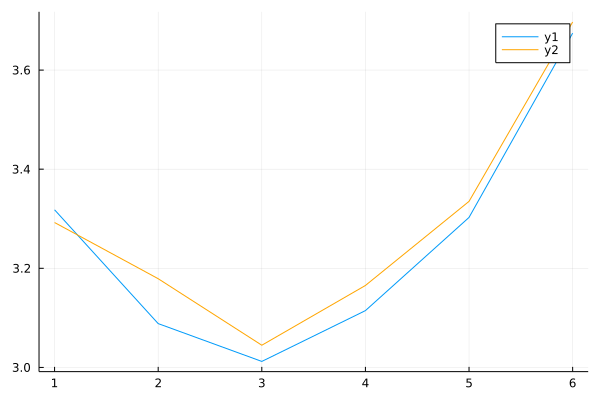

In [28]:
plot(tensorF[6,4,3,3,:,2,2,3])
plot!(dataF[6,4,3,3,:,2,2,3],color="orange")

In [29]:
resVec_mean=reshape(resVec[1],6,6,6,6,6,6,6,6);
confidence_upper=resVec[1]+2*resVec[2]; 
confidence_lower=resVec[1]-2*resVec[2];
valmat=reshape(confidence_upper,6,6,6,6,6,6,6,6); 
varmat=reshape(confidence_lower,6,6,6,6,6,6,6,6);

In [30]:
notcare,dataSiteT=dataSet8_T(2);

In [31]:
trueSin_upper=dataSiteT[end,:].+2*0.055; 
trueSin_lower=dataSiteT[end,:].-2*0.055; 

In [32]:
trueSin_upper=reshape(trueSin_upper,6,6,6,6,6,6,6,6); 
trueSin_lower=reshape(trueSin_lower,6,6,6,6,6,6,6,6);

In [33]:
trueVal=reshape(dataSiteT[end,:],6,6,6,6,6,6,6,6);

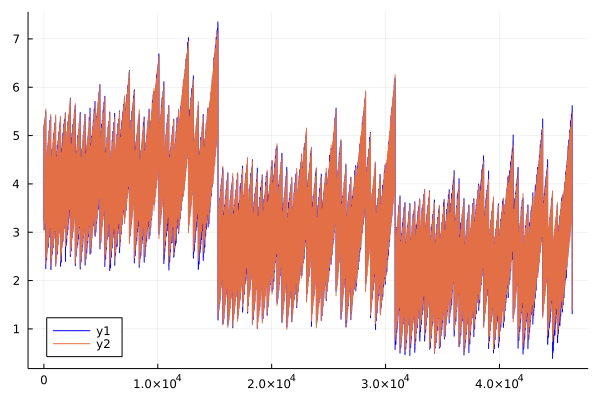

In [34]:
pss=plot(dataSite[9,800:3:140000],legend=:bottomleft, color="blue")
plot!(pss,resVec[1][800:3:140000],legend=:bottomleft)

In [35]:
st=6^4;  

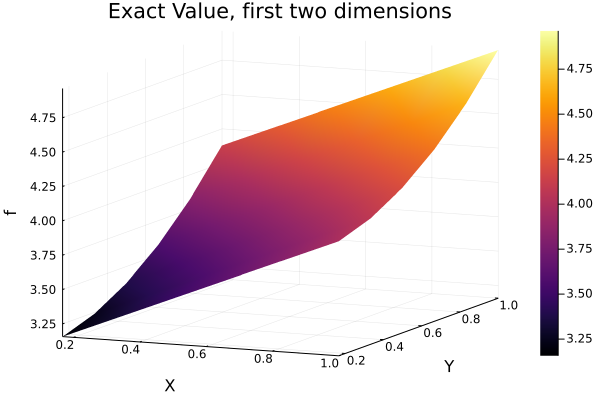

In [36]:
plotExact=plot(1.0/6*collect(1:1:6),1.0/6*collect(1:1:6),trueVal[3,:,3,:,4,6,5,3],st=:surface,xlabel="X", ylabel="Y"
    ,zlabel="f")
title!("Exact Value, first two dimensions")
#png(plotExact,"exact78.png")#1,4,3,3,4,3

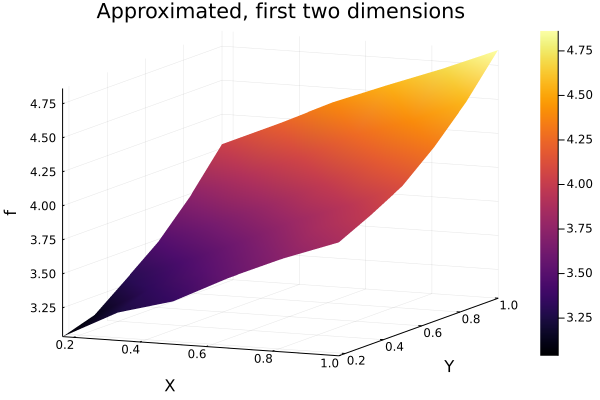

In [37]:
plotApp=plot(1.0/6*collect(1:1:6),1.0/6*collect(1:1:6),resVec_mean[3,:,2,:,4,6,5,3],st=:surface,xlabel="X",
    ylabel="Y",zlabel="f")
title!("Approximated, first two dimensions")
#png(plotApp,"app78.png")

In [38]:
sqrt(sum((resVec[1].-dataSite[end,:]).^2)/length(resVec[1]))
sum((resVec[1].-dataSite[end,:]).^2)/length(resVec[1]) # This is the chi square loss

0.0068538277413954666

In [39]:
xvec=dataSite[1,:];

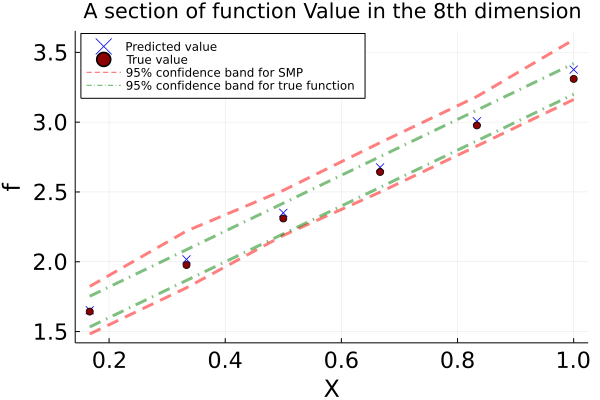

In [40]:
xcord=dataX[8,1:1:6]
    Xval1=3; Xval2=4; Xval3=4; Xval4=2;Xval5=3; Xval6=5;Xval7=4
;
plotSig=scatter(xcord,resVec_mean[1:1:6,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.1,0.95),shape=:X,color="blue2")
scatter!(xcord,trueVal[1:1:6,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],label="True value",color="red4")

plot!(xcord,varmat[1:1:6,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[1:1:6,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[1:1:6,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[1:1:6,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 8th dimension")
#png(plotSig,"large labels/plot8th.png")

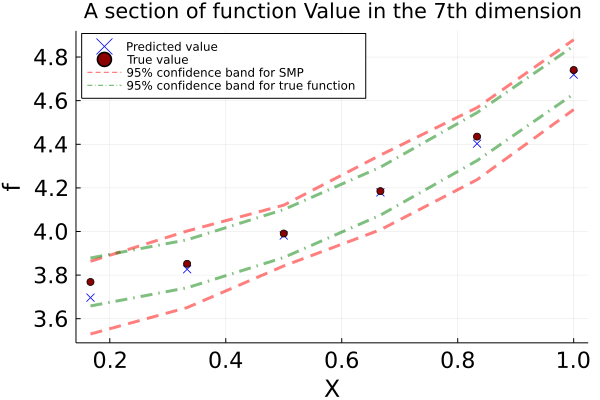

In [41]:
xcord=dataX[8,1:1:6]
Xval1=3; Xval2=5; Xval3=3; Xval4=3;Xval5=2; Xval6=3;Xval8=5;
plotSig=scatter(xcord,resVec_mean[Xval8,1:1:6,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.1,0.95),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,1:1:6,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],label="True value",color="red4")

plot!(xcord,varmat[Xval8,1:1:6,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,1:1:6,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,1:1:6,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,1:1:6,Xval6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 7th dimension")
#png(plotSig,"large labels/plot7th.png")

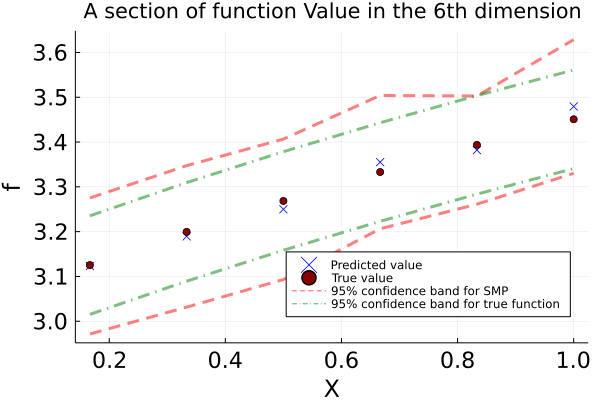

In [42]:
xcord=dataX[8,1:1:6]
Xval1=3; Xval2=5; Xval3=3; Xval4=4;Xval5=3; Xval7=3;Xval8=2

plotSig=scatter(xcord,resVec_mean[Xval8,Xval7,1:1:6,Xval5,Xval4,Xval3,Xval2,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.5,0.25),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,Xval7,1:1:6,Xval5,Xval4,Xval3,Xval2,Xval1],label="True value",color="red4")

plot!(xcord,varmat[Xval8,Xval7,1:1:6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,Xval7,1:1:6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,Xval7,1:1:6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,Xval7,1:1:6,Xval5,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 6th dimension")
#png(plotSig,"large labels/plot6th.png")

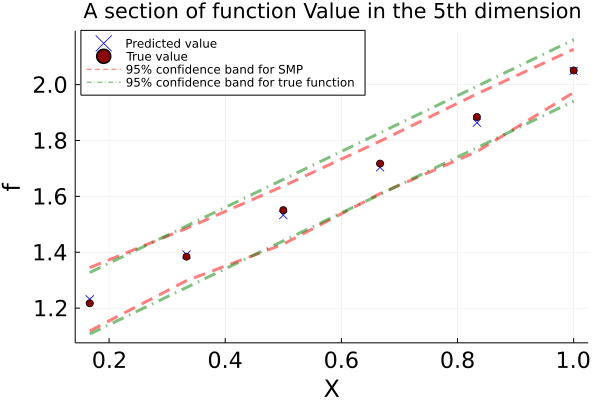

In [43]:
xcord=dataX[8,1:1:6]
Xval1=3; Xval2=2; Xval3=5; Xval4=3;Xval6=2; Xval7=1;Xval8=3
plotSig=scatter(xcord,resVec_mean[Xval8,Xval7,Xval6,1:1:6,Xval4,Xval3,Xval2,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.1,0.96),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,Xval7,Xval6,1:1:6,Xval4,Xval3,Xval2,Xval1],label="True value",color="red4")

plot!(xcord,varmat[Xval8,Xval7,Xval6,1:1:6,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,Xval7,Xval6,1:1:6,Xval4,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,Xval7,Xval6,1:1:6,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,Xval7,Xval6,1:1:6,Xval4,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 5th dimension")
#png(plotSig,"large labels/plot5th.png")

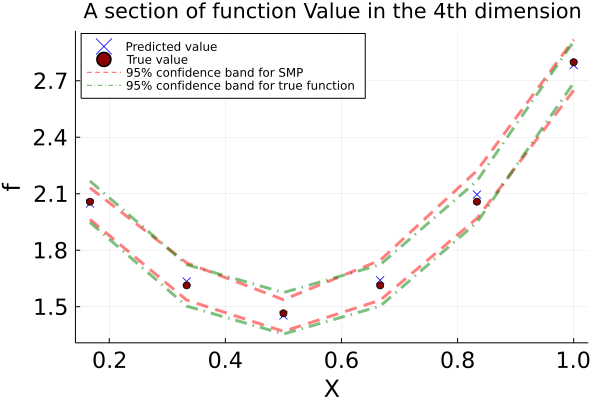

In [44]:
xcord=dataX[8,1:1:6]
#Xval1=3; Xval2=6; Xval3=2; Xval5=3; Xval6=3; Xval7=4;Xval8=3
Xval1=2; Xval2=3; Xval3=4; Xval5=3;Xval6=3; Xval7=2;Xval8=4;
#Xval1=5; Xval2=2; Xval3=4; Xval5=2;Xval6=4; Xval7=2;Xval8=4;
plotSig=scatter(xcord,resVec_mean[Xval8,Xval7,Xval6,Xval5,1:1:6,Xval3,Xval2,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.1,0.95),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,Xval7,Xval6,Xval5,1:1:6,Xval3,Xval2,Xval1],label="True value",color="red4")

plot!(xcord,varmat[Xval8,Xval7,Xval6,Xval5,1:1:6,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,Xval7,Xval6,Xval5,1:1:6,Xval3,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,Xval7,Xval6,Xval5,1:1:6,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,Xval7,Xval6,Xval5,1:1:6,Xval3,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 4th dimension")
#png(plotSig,"large labels/plot4th.png")

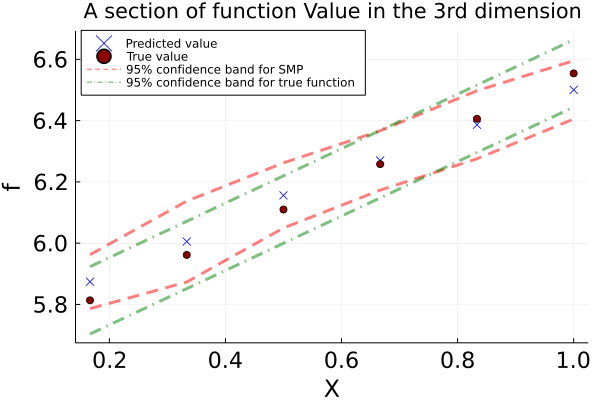

In [45]:
xcord=dataX[8,1:1:6]
#Xval1=3; Xval2=6; Xval3=2; Xval5=3; Xval6=3; Xval7=6;Xval8=3
#Xval1=2; Xval2=3; Xval3=4; Xval5=3;Xval6=3; Xval7=2;Xval8=4;
Xval1=4; Xval2=6; Xval4=1; Xval5=5;Xval6=1; Xval7=2;Xval8=6;
plotSig=scatter(xcord,resVec_mean[Xval8,Xval7,Xval6,Xval5,Xval4,1:1:6,Xval2,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.1,0.96),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,Xval7,Xval6,Xval5,Xval4,1:1:6,Xval2,Xval1],label="True value",color="red4")

plot!(xcord,varmat[Xval8,Xval7,Xval6,Xval5,Xval4,1:1:6,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,Xval7,Xval6,Xval5,Xval4,1:1:6,Xval2,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,Xval7,Xval6,Xval5,Xval4,1:1:6,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,Xval7,Xval6,Xval5,Xval4,1:1:6,Xval2,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 3rd dimension")
#png(plotSig,"large labels/plot3rd.png")

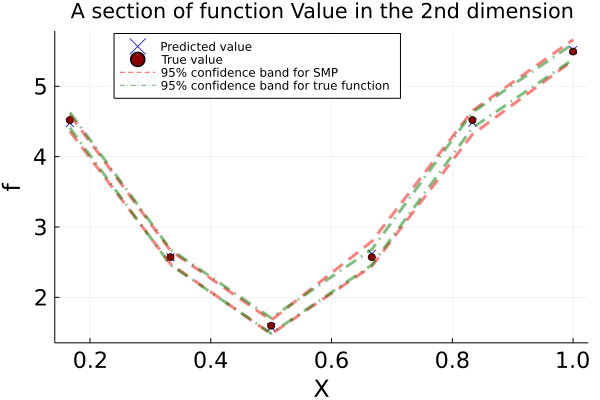

In [46]:
xcord=dataX[8,1:1:6]
#Xval1=3; Xval2=6; Xval3=2; Xval5=3; Xval6=3; Xval7=6;Xval8=3
#Xval1=2; Xval2=3; Xval3=4; Xval5=3;Xval6=3; Xval7=2;Xval8=4;
Xval1=4; Xval3=4; Xval4=4; Xval5=5;Xval6=4; Xval7=3;Xval8=4;
plotSig=scatter(xcord,resVec_mean[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,1:1:6,Xval1],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.2,0.95),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,1:1:6,Xval1],label="True value",color="red4")

plot!(xcord,varmat[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,1:1:6,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,1:1:6,Xval1],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,1:1:6,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,1:1:6,Xval1],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 2nd dimension")
#png(plotSig,"large labels/plot2nd.png")

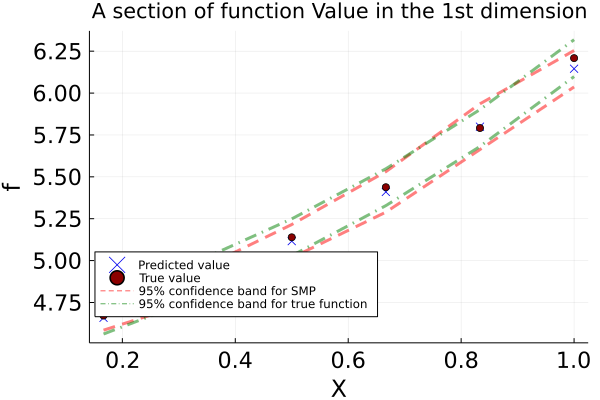

In [47]:
# xcord=dataX[8,1:1:6]
Xval1=3; Xval2=6; Xval3=2; Xval5=3; Xval6=3; Xval7=6;Xval8=3
#Xval1=2; Xval2=3; Xval3=4; Xval5=3;Xval6=3; Xval7=2;Xval8=4;
#Xval2=2; Xval3=2; Xval4=3; Xval5=3;Xval6=1; Xval7=3;Xval8=2;
plotSig=scatter(xcord,resVec_mean[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,1:1:6],label="Predicted value",legendfontsize=10
,xtickfontsize=15,ytickfontsize=15,xguidefontsize=16,yguidefontsize=16,legend=(0.1,0.25),shape=:X,color="blue2")
scatter!(xcord,trueVal[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,1:1:6],label="True value",color="red4")

plot!(xcord,varmat[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,1:1:6],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label="95% confidence band for SMP")
plot!(xcord,valmat[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,1:1:6],linestyle=:dash,color="red",lw=3,linealpha = 0.5,label=false)

plot!(xcord,trueSin_upper[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,1:1:6],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label="95% confidence band for true function")
plot!(xcord,trueSin_lower[Xval8,Xval7,Xval6,Xval5,Xval4,Xval3,Xval2,1:1:6],linestyle=:dashdot,lw=3,linealpha = 0.5,
    color="green",label=false)
xlabel!("X")
ylabel!("f")
title!("A section of function Value in the 1st dimension")
#png(plotSig,"large labels/plot1st.png")